<a href="https://colab.research.google.com/github/varsha2509/Springboard-DS/blob/master/Capstone2/Colab/DeepSat6_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install Packages and Mount Google Drive
import pandas as pd
import numpy as np
import cv2
import h5py
import csv
from scipy.io import loadmat
import matplotlib.pyplot as plt 
from google.colab import drive
import os
from os import listdir

from numpy import asarray

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.preprocessing import image
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, ZeroPadding2D
from keras.models import Sequential, Model
from keras.applications import vgg16
from keras import backend as K
from keras import models    
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import balanced_accuracy_score

from matplotlib.colors import ListedColormap


from multiprocessing.pool import ThreadPool



from keras.callbacks import EarlyStopping, ModelCheckpoint

# load vgg model
from keras.applications.vgg16 import VGG16


from skimage.io import imread

from glob import glob

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset/"

#Mount the drive to colab notebook
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Change the current working directory
%cd /content/gdrive/My\ Drive/Springboard/Capstone\ Projects/Capstone-2/DeepSat-6-Dataset/


/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset


# Loading and Cleaning Dataset





In [3]:
## Load the .mat file to data
data=loadmat('/content/gdrive/My Drive/Springboard/Capstone Projects/Capstone-2/DeepSat-6-Dataset/sat-6-full.mat')

In [4]:
## Create individual nparrays for train and test from mat
Xtrain = data['train_x'].reshape(-1, 28, 28, 4) #This moves the position of the last column to the first, and clips the RGB values between (0,255)
ytrain = data['train_y'].T #Transposes the y_train array to be of size (324,000,6)
Xtest = data['test_x'].reshape(-1, 28,28,4) #Same as Xtrain
ytest = data['test_y'].T #Same as ytrain

In [5]:
Xtrain = np.moveaxis(data['train_x'], -1, 0)
Xtest = np.moveaxis(data['test_x'], -1, 0)

In [6]:
Xtrain[1]

array([[[177, 152, 129, 183],
        [180, 154, 128, 182],
        [181, 156, 129, 180],
        ...,
        [184, 164, 133, 177],
        [185, 164, 140, 179],
        [192, 172, 135, 179]],

       [[176, 152, 127, 184],
        [181, 155, 132, 183],
        [178, 152, 131, 182],
        ...,
        [181, 165, 137, 181],
        [185, 167, 141, 180],
        [194, 173, 147, 180]],

       [[178, 156, 130, 186],
        [185, 157, 131, 184],
        [185, 158, 131, 183],
        ...,
        [184, 162, 136, 181],
        [190, 170, 145, 182],
        [196, 177, 145, 181]],

       ...,

       [[184, 168, 143, 178],
        [192, 170, 145, 176],
        [196, 171, 143, 174],
        ...,
        [183, 166, 139, 178],
        [180, 165, 134, 178],
        [176, 158, 134, 174]],

       [[186, 164, 137, 174],
        [188, 166, 135, 173],
        [190, 169, 139, 174],
        ...,
        [178, 161, 135, 173],
        [182, 161, 136, 173],
        [180, 162, 137, 173]],

       [[182

In [7]:
#Load the annotations as individual array
annotations = data['annotations']
annotations

array([[array(['100000'], dtype='<U6'), array(['building'], dtype='<U8')],
       [array(['010000'], dtype='<U6'),
        array(['barren land'], dtype='<U11')],
       [array(['001000'], dtype='<U6'), array(['trees'], dtype='<U5')],
       [array(['000100'], dtype='<U6'),
        array(['grassland'], dtype='<U9')],
       [array(['000010'], dtype='<U6'), array(['road'], dtype='<U4')],
       [array(['000001'], dtype='<U6'), array(['water'], dtype='<U5')]],
      dtype=object)

In [8]:
#Create a dictionary with values as land categories
land_categories = dict()
for an in range(len(annotations)):
  land_categories[an] = annotations[an][1][0]
land_categories

{0: 'building',
 1: 'barren land',
 2: 'trees',
 3: 'grassland',
 4: 'road',
 5: 'water'}

In [9]:
#Map ytrain and ytest with label names
ytrain_cat = pd.DataFrame(ytrain).idxmax(axis=1).map(land_categories)
ytest_cat = pd.DataFrame(ytest).idxmax(axis=1).map(land_categories)

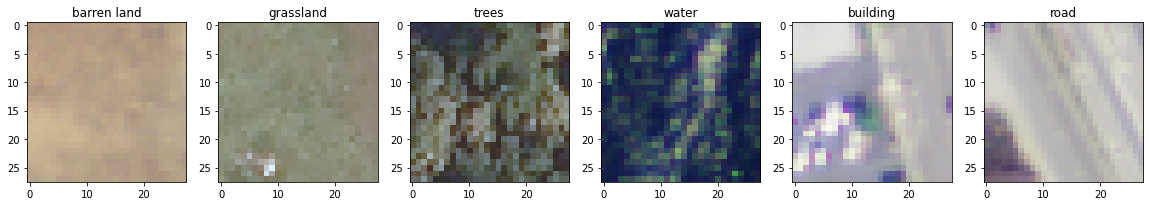

In [10]:
#Plot some sample figures for exploration
fig,ax =plt.subplots(1,6,figsize=(20,10))
ax[0].imshow(Xtrain[1,:,:,:3], cmap='gray', vmin = 0, vmax = 255)
ax[1].imshow(Xtrain[29,:,:,:3])
ax[2].imshow(Xtrain[53,:,:,:3])
ax[3].imshow(Xtrain[7,:,:,:3])
ax[4].imshow(Xtrain[81,:,:,:3])
ax[5].imshow(Xtrain[258,:,:,:3])
ax[0].set_title(ytrain_cat[1])
ax[1].set_title(ytrain_cat[29])
ax[2].set_title(ytrain_cat[53])
ax[3].set_title(ytrain_cat[287])
ax[4].set_title(ytrain_cat[81])
ax[5].set_title(ytrain_cat[258]);

# Building Simple CNN model using Keras


### Use ImageDataGenerator to split dataset to training and validation

In [ ]:
## Specify inputs
img_width = 28
imh_height = 28
batch_size = 64

In [ ]:
#Using ImageDataGenerator to split training data to train and validation set
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

val_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

train_generator = train_datagen.flow(
    Xtrain[:,:,:,:3], ytrain, 
    batch_size=batch_size, shuffle = True, 
    subset='training') # set as training data

validation_generator = val_datagen.flow(
    Xtrain[:,:,:,:3], ytrain,  # same directory as training data
    batch_size=batch_size, shuffle = True, 
    subset='validation') # set as validation data

## Define a function to calculate f1 metric, precicion and recall

Keras 2.0 metrics f1, precision, and recall have been removed. The solution is to use a custom metric function. ([Ref](https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras))

In [ ]:
#Define a custom function to calculate precicion, recall, f-1 score 
def f_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f_f1score ( y_true, y_pred):
    precision = f_precision(y_true, y_pred)
    recall = f_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




def f_balanced_accuracy(y_true, y_pred):
      
      ## Sensitivity
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      sensitivity = true_positives / (possible_positives + K.epsilon())
      
      ### Specificity
      true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
      possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
      specificity =  true_negatives / (possible_negatives + K.epsilon())
      balanced_accuracy = (sensitivity + specificity) / 2
      return balanced_accuracy







#### Ref: https://www.deepideas.net/unbalanced-classes-machine-learning/


# # def auroc(y_true, y_pred):
# #   return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
# auc_metrics = tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
#      dtype=None, thresholds=None, multi_label=False, label_weights=None)


## Building Baseline Convolution Neural Nets Model

In [ ]:
## Building the CNN model
num_classes = 6

model = Sequential([
  layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape = (28,28,3)), #First convolution layer with 16 filters
#  layers.MaxPooling2D(pool_size = (3,3)),
  layers.Conv2D(32, (3,3), activation='relu'), #Second convolution layer with 32 filters
  layers.MaxPooling2D(pool_size = (3,3)),                     #Dimensionality reduction through pooling
  layers.Conv2D(64, (3,3), activation='relu'),  #Third convolution layer with 64 filters
  layers.MaxPooling2D(pool_size = (3,3)),                     #Dimensionality reduction through pooling
  layers.Dropout(0.2),                           #Dropout to prevent overfitting
  layers.Flatten(),                             #flatten before dense layer
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),                           #Dropout to prevent overfitting
  layers.Dense(num_classes, activation = 'softmax')
])


In [ ]:
### In this case, we are optimizing for loss and all other metrics are tracked
### Cross-entropy loss increases as the predicted probability diverges from the actual label, so the goal is to minimize loss
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy', f_f1score, f_precision, f_recall, f_balanced_accuracy])

In [ ]:
#Simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#es = EarlyStopping(patience = 3, monitor = 'val_loss', verbose = 1, mode = 'min')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_f_balanced_accuracy',
                               verbose=1, 
                               mode = 'max',
                               save_best_only=True)


### Ref -https://machinelearningmastery.com/check-point-deep-learning-models-keras/

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [ ]:
#tbcallback = TensorBoard(log_dir='./Graph/', histogram_freq=1, write_graph=True)

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=150,
    epochs = 20, 
    validation_data=validation_generator, verbose = 1, callbacks = [checkpointer], validation_steps = 50, workers = 4, use_multiprocessing = True)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
149/150 [============================>.] - ETA: 0s - loss: 0.8461 - accuracy: 0.6856 - f_f1score: 0.6030 - f_precision: 0.7752 - f_recall: 0.5240 - f_balanced_accuracy: 0.7535WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_f_balanced_accuracy improved from -inf to 0.90556, saving model to best_weights.hdf5
150/150 [==============================] - 6s 43ms/step - loss: 0.8427 - accuracy: 0.6868 - f_f1score: 0.6047 - f_precision: 0.7761 - f_recall: 0.5260 - f_balanced_accuracy: 0.7545 - val_loss: 0.3650 - val_accuracy: 0.8737 - val_f_f1score: 0.8624 - val_f_precision: 0.8980 - val_f_recall: 0.8300 - val_f_balanced_accuracy: 0.9056
Epoch 2/20
149/150 [============================>.] - ETA: 0s - loss: 0.3151 - accuracy: 0.8775 - f_f1score: 0.8769 - f_precision: 0.8957 

## Evaluate Model Performance


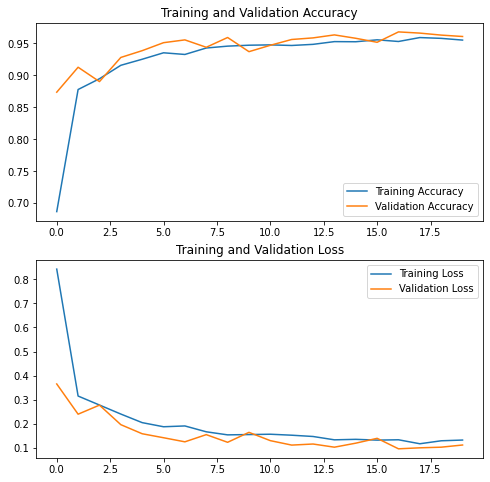

In [ ]:
epochs = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Saving and loading model weights



In [ ]:
# serialize model to JSON
json_file = model.to_json()
with open("cnn-baseline.json", "w") as f:
    f.write(json_file)

# serialize weights to HDF5
model.save_weights("cnn-baseline.h5")
print("Saved model to disk")
 
model.save("baseline_cnn.tf")

# later...
 




Saved model to disk


In [11]:
# load json and create model
json_file = open('cnn-baseline.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("cnn-baseline.h5")
print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk


# Evaluate Test Data

In [ ]:
# Evaluate model performance on test dataset
Xtest_rescaled = Xtest[:,:,:,:3]/255

predictions = loaded_model.predict(Xtest_rescaled)


In [ ]:
#Map predictions to actual categories
preds_cat = pd.DataFrame(predictions).idxmax(axis=1).map(land_categories)


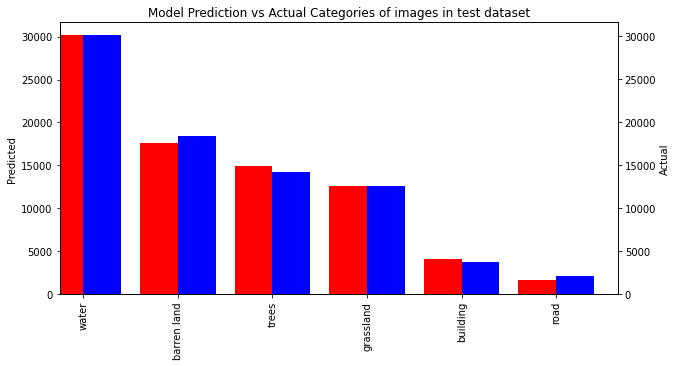

In [ ]:
# Plot predicted vs actual results 
pred_counts =preds_cat.value_counts()
act_counts = ytest_cat.value_counts()


fig=plt.figure(figsize=(10,5))

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

pred_counts.plot(kind='bar', color='red', ax=ax, width=width, position=1)
act_counts.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Predicted')
ax2.set_ylabel('Actual')

ax.set_title('Model Prediction vs Actual Categories of images in test dataset')

plt.show()



#### Classification Report, Accuracy and Confusion Matrix


In [ ]:
#Print classification report
cr = classification_report(ytest_cat, preds_cat)
print(cr)

              precision    recall  f1-score   support

 barren land       0.98      0.94      0.96     18367
    building       0.88      0.98      0.93      3714
   grassland       0.93      0.92      0.92     12596
        road       0.94      0.74      0.83      2070
       trees       0.95      1.00      0.97     14185
       water       1.00      1.00      1.00     30068

    accuracy                           0.97     81000
   macro avg       0.95      0.93      0.94     81000
weighted avg       0.97      0.97      0.97     81000



In [ ]:
#Print Balanced accuracy
print('Overall Balanced Accuracy: %2.2f%%' % (100*balanced_accuracy_score(ytest_cat, preds_cat)))

Overall Balanced Accuracy: 93.11%


In [ ]:
#Print overall accuracy
print('Overall Accuracy: %2.2f%%' % (100*accuracy_score(ytest_cat, preds_cat)))

Overall Accuracy: 96.72%


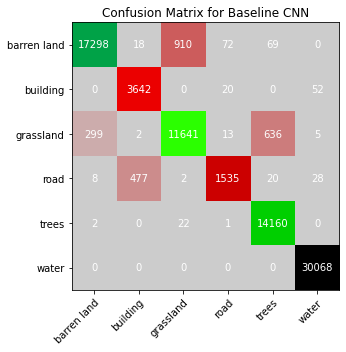

In [ ]:
#Plot confusion matrix
cm = confusion_matrix(ytest_cat, preds_cat)

fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cm, cmap = plt.cm.nipy_spectral_r)

# We want to show all ticks...
ax.set_xticks(np.arange(len(land_categories)))
ax.set_yticks(np.arange(len(land_categories)))
# ... and label them with the respective list entries
ax.set_xticklabels(['barren land','building','grassland','road','trees','water'])
ax.set_yticklabels(['barren land','building','grassland','road','trees','water'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion Matrix for Baseline CNN")
fig.tight_layout()
plt.show()

#### Determining Prediction Errors

In [ ]:
#Create dataframe to store actual and predicted categories
prediction_err  = pd.DataFrame()
prediction_err = prediction_err.append([ytest_cat, preds_cat]).T
prediction_err.columns = ['Actual','Predicted']
prediction_err.head()

Actual    Predicted
0        trees        trees
1        trees        trees
2        water        water
3  barren land  barren land
4        water        water

In [ ]:
#Determine mismatches by comapring both labels
pred_mismatch = prediction_err.loc[(prediction_err.Actual != prediction_err.Predicted)]
print('Overall total mismatches:' , (len(pred_mismatch)))

Overall total mismatches: 2656


In [ ]:
### Reset index in pred_mismatch such that first column is the row number in prediction_error
pred_mismatch.reset_index(inplace=True)
pred_mismatch.head()

index       Actual  Predicted
0     37  barren land  grassland
1     56        trees  grassland
2     92  barren land  grassland
3    105    grassland      trees
4    135  barren land       road

In [ ]:
e1 = pred_mismatch[(pred_mismatch['Actual'].values == 'barren land')].head(1)['index'].values.item()
e2 = pred_mismatch[(pred_mismatch['Actual'].values == 'building')].head(1)['index'].values.item()
e3 = pred_mismatch[(pred_mismatch['Actual'].values == 'grassland')].head(1)['index'].values.item()
e4 = pred_mismatch[(pred_mismatch['Actual'].values == 'road')].head(1)['index'].values.item()
e5 = pred_mismatch[(pred_mismatch['Actual'].values == 'trees')].head(1)['index'].values.item()
#Water class, remove if accuracy = 1
#e6 = pred_mismatch[(pred_mismatch['Actual'].values == 'water')].head(1)['index'].values.item()

Count the number of mismatches in each category

In [ ]:
#Create a dataframe of total mismatches using group by
mismatch_df = pred_mismatch.groupby(['Actual']).describe().reset_index()


#Drop columns that are not needed
mismatch_df = mismatch_df.drop(mismatch_df.columns[[2,3,4,5,6,7,8]], axis = 1)


##Rename columns
mismatch_df.columns = [('Class'), ('Total Mismatches')]

In [ ]:
mismatch_df.head()

Class  Total Mismatches
0  barren land            1069.0
1     building              72.0
2    grassland             955.0
3         road             535.0
4        trees              25.0

## Plotting some images where the model predictions were incorrect

Text(0.5, 1.0, 'Predicted Label: grassland\nTrue Label: trees')

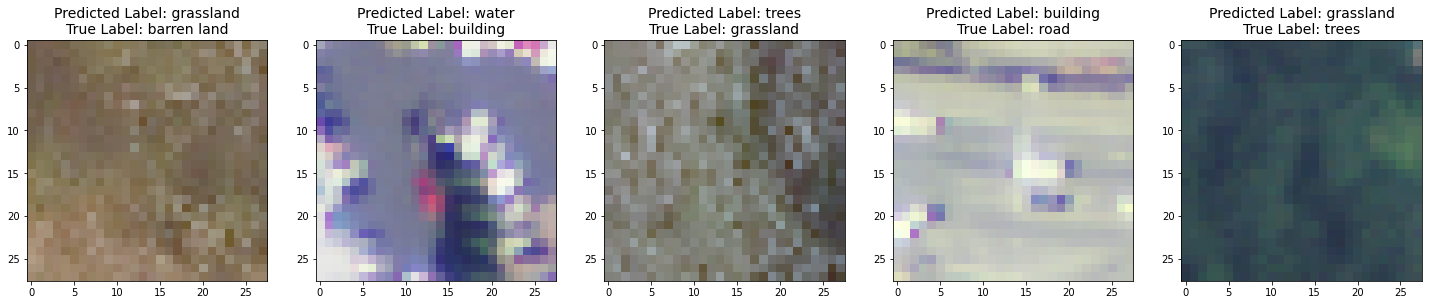

In [ ]:
#Plot some sample figures for exploration
fig,ax =plt.subplots(1,5,figsize=(25,15))
ax[0].imshow(Xtest[e1,:,:,:3], cmap='gray', vmin = 0, vmax = 255)
ax[1].imshow(Xtest[e2,:,:,:3])
ax[2].imshow(Xtest[e3,:,:,:3])
ax[3].imshow(Xtest[e4,:,:,:3])
ax[4].imshow(Xtest[e5,:,:,:3])
#ax[5].imshow(Xtest[746,:,:,:3])
ax[0].set_title("Predicted Label: " + prediction_err.loc[e1, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e1, 'Actual'], fontsize = 14)
ax[1].set_title("Predicted Label: " + prediction_err.loc[e2, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e2, 'Actual'], fontsize = 14)
ax[2].set_title("Predicted Label: " + prediction_err.loc[e3, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e3, 'Actual'], fontsize = 14)
ax[3].set_title("Predicted Label: " + prediction_err.loc[e4, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e4, 'Actual'], fontsize = 14)
ax[4].set_title("Predicted Label: " + prediction_err.loc[e5, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[e5, 'Actual'], fontsize = 14)
#ax[5].set_title("Predicted Label: " + prediction_err.loc[746, 'Predicted']+ '\n' +"True Label: "+prediction_err.loc[746, 'Actual'], fontsize = 14);


# Making Predictions on a new image







The input image in the JPEG2000 format was converted to png using 'gdal_translate' outside of Google colab. The original image is of size (11606, 15729) and the image is resized into a smaller image (5600 by 5600) and saved as a png. 

In [12]:
##### Dont not run this cell#####################
#################################

img_path = './NAIP-Redding-2.png'


from PIL import Image
 # My image is a 200x374 jpeg that is 102kb large
foo = Image.open(img_path)
print(foo.size)
#   (200,374)
#  # I downsize the image with an ANTIALIAS filter (gives the highest quality)
foo = foo.resize((5600,5600),Image.ANTIALIAS)
foo.save("./NAIP-Redding-2-small.png")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (177328074 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


(11606, 15279)


KeyboardInterrupt: ignored

### Single label image classification

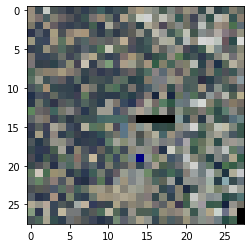

(1, 28, 28, 3)


In [12]:
img_path = './NAIP-Redding-2-small.png'

img = image.load_img(img_path, target_size = (28,28,3))

img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis = 0)

img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)


In [13]:
# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
#classes = model.predict_classes(images, batch_size=10)
classes  = (loaded_model.predict(images) > 0.5).astype("int32")

#Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
print("Predicted class is:",classes)

Predicted class is: [[1 0 0 0 0 0]]


### Multi label image classification

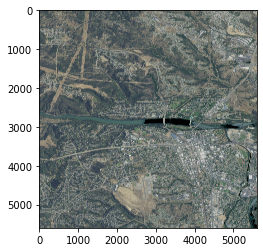

(1, 5600, 5600, 3)


In [28]:
#Print the original image
img_path = './NAIP-Redding-2-small.png'
img = image.load_img(img_path, target_size = (5600,5600,3))
img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis = 0)

img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)



In [16]:
## Determine exact image size
im=Image.open(img_path)
im.size # (width,height) tuple

(5600, 5600)

**Split multiband image into image tiles using GDAL**

In [ ]:

#### Do-Not Run this cell. JPG files have already been created!!##################3

import os, gdal

input_filename = img_path

out_path = './NAIP-2/'
output_filename = 'tile_'

tile_size_x = 28
tile_size_y = 28

ds = gdal.Open(input_filename)
band = ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

for i in range(2660, xsize, tile_size_x):
    for j in range(0, 5208, tile_size_y):
        com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(input_filename) + " " + str(out_path) + str(output_filename) + str(i) + "_" + str(j) + ".jpg"
        os.system(com_string)

In [ ]:
out_path = './NAIP-2/'

In [ ]:
len(listdir(out_path))

40000

In [ ]:
##### This code below first creates a dictionary witfolder
  all_files[i] = set()
  for j in range(0, 5600, 28):
    all_files[i].add(j)
    
#print(all_files[2520])
for filename in listdir(out_path):
  prefix, _ = filename.split('.')
  _, file_i, file_j = prefix.split('_')
  target_set = all_files[int(file_i)]
  target_set.remove(int(file_j))

sum_v = 0
for k,v in all_files.items():
  if len(v) > 0:
    #print((k, len(v))) 
    sum_v = sum_v + len(v)


#print(sum_v)

In [ ]:
### This code checks each file name 'tile_i_j' and checks if each file is in the finished set. If file name is not in finished set, it appends it to unfinished_tile list
unfinished_tiles = []
finished_set = set()

for filename in listdir(out_path):
  finished_set.add(filename)


for i in range(0, 5600, 28):
  for j in range(0, 5600, 28):
    # Check if tile_i_j is in list of files that you have already computed
    #for filename in listdir(out_path):
    if 'tile_{}_{}.jpg'.format(i,j) not in finished_set:
      unfinished_tiles.append((i,j))

len(unfinished_tiles)

0

In [ ]:
### This code groups all the unfinished tiles into 10 batches; this is done to be able to
## call the gdal_translate function using a multi thread process, and to do a batch processing of the gdal translate
i = 0
grouped_unfinished_tiles = []
for j in range(10):
  grouped_unfinished_tiles.append([])


while i < len(unfinished_tiles):
    grouped_unfinished_tiles[i%10].append(unfinished_tiles[i])
    i+=1


for i in grouped_unfinished_tiles:
  print(len(i))



1243
1243
1242
1242
1242
1242
1242
1242
1242
1242


In [ ]:
# Gdal_translate multi-thread processing on the unfinished images
def gdal_img_translate(batch):
  tile_size_x = 28
  tile_size_y = 28
  input_filename = img_path
  out_path = './NAIP-2/'
  output_filename = 'tile_'
  for i,j in batch:
    com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(input_filename) + " " + str(out_path) + str(output_filename) + str(i) + "_" + str(j) + ".jpg"
    os.system(com_string)

async_result = [] #Create an empty list which stores the 
pool = ThreadPool(processes=20)
    
for batch in grouped_unfinished_tiles:
  thread_result = pool.apply_async(gdal_img_translate, [batch])
  async_result.append(thread_result)



for res in async_result: #loop through each async_result object
  res.get() #using the .get() function to wait for thread to complete


**Make predictions on each GDAL file**

In [14]:
out_path = 'NAIP-2/'


In [17]:
len(files)

40000

In [16]:
files = []
files = listdir(out_path)

In [20]:
#### Making predictions on each jpg file
# load all images into memory
def make_predictions(folder, files):
  count = 0
  predicted_classes, file_tags = list(), list()
  # enumerate files in the directory
  import time
  try:
    for filename in files:
      photo = image.load_img((folder + filename), target_size = (28,28)) #load image

      img_tensor = image.img_to_array(photo)  # convert to numpy array

      img_tensor = np.expand_dims(img_tensor, axis = 0)
      #img_tensor /= 255.
      images = np.vstack([img_tensor]) #The loaded_model takes in an array of size (n, 28, 28, channels) where n is the number of images. Here we add this extra dimension with a value of 1
      # get tags
      tag = filename[:-4]

      # Predictions
      predicted_class = (loaded_model.predict(images) > 0.5).astype("int32")

      # store
      #photos_all.append(images)
      predicted_classes.append(predicted_class)
      file_tags.append(tag)
    
      #photos = asarray(photos_all, dtype='uint8')
      predictions = asarray(predicted_classes, dtype='uint8')
      tags = asarray(file_tags)
      count = count +1
      print(filename, "done")
  except Exception as e:
    print(tag, count)
    raise e
  return predictions, tags

In [21]:
predictions_array, file_tags = make_predictions(out_path, files)

Streaming output truncated to the last 5000 lines.
tile_560_2324.jpg done
tile_560_2352.jpg done
tile_560_2380.jpg done
tile_560_2408.jpg done
tile_560_2436.jpg done
tile_560_2464.jpg done
tile_560_2492.jpg done
tile_560_2520.jpg done
tile_560_2548.jpg done
tile_560_2576.jpg done
tile_560_2604.jpg done
tile_560_2632.jpg done
tile_560_2660.jpg done
tile_560_2688.jpg done
tile_560_2716.jpg done
tile_560_2744.jpg done
tile_560_2772.jpg done
tile_560_2800.jpg done
tile_560_2828.jpg done
tile_560_2856.jpg done
tile_560_2884.jpg done
tile_560_2912.jpg done
tile_560_2940.jpg done
tile_560_2968.jpg done
tile_560_2996.jpg done
tile_560_3024.jpg done
tile_560_3052.jpg done
tile_560_3080.jpg done
tile_560_3108.jpg done
tile_560_3136.jpg done
tile_560_3164.jpg done
tile_560_3192.jpg done
tile_560_3220.jpg done
tile_560_3248.jpg done
tile_560_3276.jpg done
tile_560_3304.jpg done
tile_560_3332.jpg done
tile_560_3360.jpg done
tile_560_3388.jpg done
tile_560_3416.jpg done
tile_560_3444.jpg done
tile_5

In [22]:
#Convert the 3d predictions_array to 2D array
predictions = []
for preds in predictions_array: 
    for pred in preds: 
        predictions.append(pred) 


In [23]:
## Mapping predictions to actual categories
NAIP_image_df = pd.DataFrame()
NAIP_image_df['Class'] = pd.DataFrame(predictions).idxmax(axis=1).map(land_categories)

In [24]:
#assign all file tags to a new columns
NAIP_image_df['File_tags'] = file_tags


In [31]:
tile_size_x = 28
tile_size_y = 28
count_bld = 0
count_bar = 0
count_trees = 0
count_grass = 0
count_road = 0
count_water = 0
 
#Split the file tags into three columns and drop the "Tile" column
NAIP_image_df[['Tile', 'Col', 'Row']] = NAIP_image_df['File_tags'].str.split('_', expand = True, )
NAIP_image_df.drop(columns= 'Tile', inplace=True)

#Divide each row and column by the image tile size
NAIP_image_df['Row'] = (NAIP_image_df['Row'].astype(int)/tile_size_x)
NAIP_image_df['Col'] = (NAIP_image_df['Col'].astype(int)/tile_size_y)
 
## Map each land class to integers
for index in range(len(NAIP_image_df)):
  if NAIP_image_df.loc[index,'Class'] == 'building':
    NAIP_image_df.loc[index,'ClassType'] = 0
    count_bld +=1
  elif NAIP_image_df.loc[index,'Class'] == 'barren land':
    NAIP_image_df.loc[index,'ClassType'] = 1
    count_bar +=1
  elif NAIP_image_df.loc[index, 'Class'] == 'trees':
    NAIP_image_df.loc[index, 'ClassType'] = 2
    count_trees +=1
  elif NAIP_image_df.loc[index, 'Class'] == 'grassland':
    NAIP_image_df.loc[index, 'ClassType'] = 3
    count_grass +=1
  elif NAIP_image_df.loc[index, 'Class'] == 'road':
    NAIP_image_df.loc[index, 'ClassType'] = 4
    count_road +=1
  elif NAIP_image_df.loc[index, 'Class'] == 'water':
    NAIP_image_df.loc[index, 'ClassType'] = 5
    count_water +=1


In [32]:
## Create image
NAIP_image =NAIP_image_df.pivot('Row','Col','ClassType').to_numpy()
NAIP_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 5., 5., 5.],
       [0., 0., 0., ..., 5., 5., 2.],
       [0., 0., 0., ..., 5., 3., 5.]])

Text(0.5, 1.0, 'Original Image')

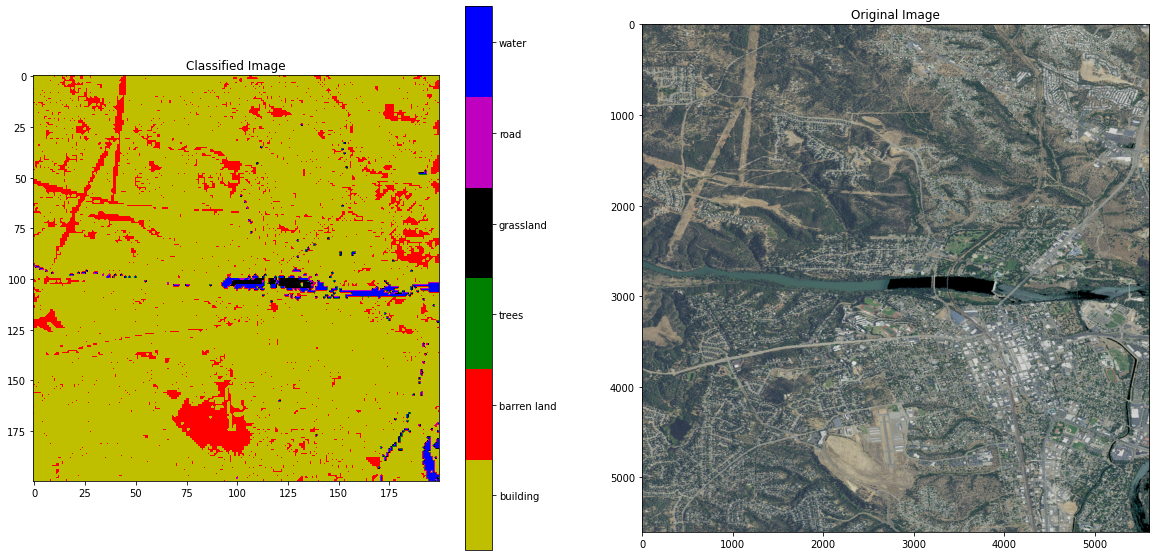

In [33]:
#Display image classifications

#First creating a color mapping scheme for each land class type
cmap_classes=ListedColormap(['y','r','g','k','m','b'])#custom colormap
#y - building, r - barren land, g - trees, black - grasslands, magenta - road, cyan - water

#Next plot the mapped image and the original image size by side
fig,ax=plt.subplots(1,2,figsize=(20,10))

im=ax[0].imshow(NAIP_image,cmap=cmap_classes)

cbar = fig.colorbar(im, ax=ax[0])
cbar.set_ticks(np.linspace(0.5, 5.5, 7))
cbar.ax.set_yticklabels([land_categories[i] for i in range(6)])
ax[0].set_title('Classified Image')

ax[1].imshow(img_tensor[0])
ax[1].set_title('Original Image')

In [35]:
print("Number of tiles in each category:", "\n")
print("Buildings:", count_bld, "\n", "Barren Land:", count_bar, "\n", "Grassland:", count_grass, "\n","Trees:", count_trees, "\n", "Road:", count_road, "\n", "Water:", count_water, "\n")

Number of tiles in each category: 

Buildings: 33889 
 Barren Land: 5443 
 Grassland: 122 
 Trees: 5 
 Road: 12 
 Water: 529 



# Visualizing Filters of only the convolution layers

 1) Iterate through all layers using model.layers

2) Identify convolution layers and use get_weights to get weights and biases

 3) Normalize weight to between 0 and 1
 
4) Plot filters for each layer and channel

conv2d (3, 3, 3, 16)
16


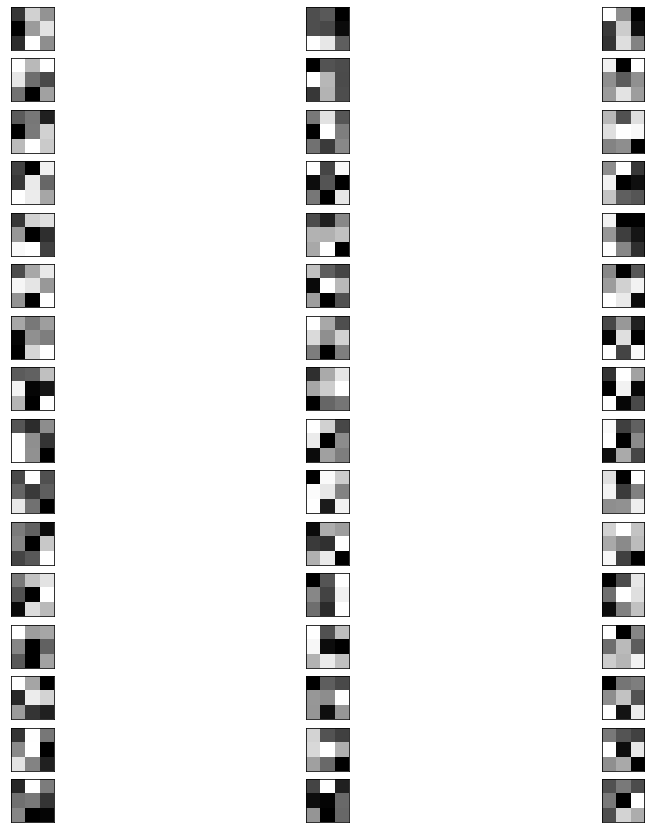

conv2d_1 (3, 3, 16, 32)
32


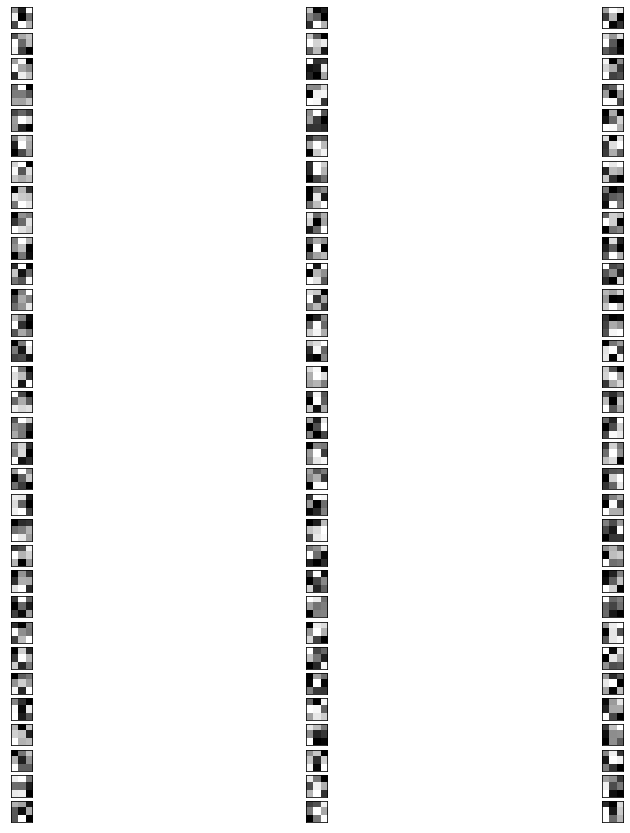

conv2d_2 (3, 3, 32, 64)
64


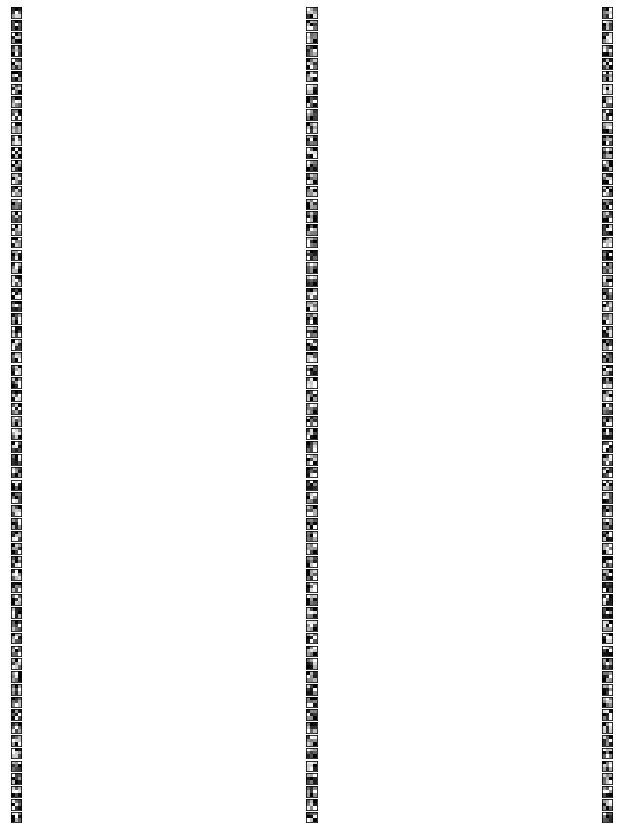

In [ ]:
#summarize filter shapes
for layer in model.layers: 
  #check for conv layer
  if 'conv' in layer.name:
    #get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

    #Step 2: Normalize filters between 0 and 1
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min)/(f_max - f_min)
    print(filters.shape[3])
    filter_cnt = 1
    plt.figure(figsize = (15,15))
    #plotting all filters
    for i in range(filters.shape[3]):
      #get filters
      f = filters[:,:,:,i]
      #Plot each channel in the RGB channel
      for j in range(filters.shape[0]):
        ax  = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:,:,j], cmap = 'gray')
        filter_cnt +=1
    plt.show()


# Visualizing intermediate activations



In this technique, given an input image, we will simply plot what each filter has extracted (output features) after a convolution operation in each layer.



#### Instantiating a model from an input tensor and a list of output tensors

In [ ]:
## Define a new class Model with input = image and output = intermediate representations of all layers in the sarting from the second layer
layers_outputs = [layer.output for layer in model.layers[:12]]

#Activation model
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layers_outputs) # Creates a model that will return these outputs, given the model input

#Load input image
#img = load_img(img_path, target_size=(150, 150, ))

#### Running the model in predict mode

In [ ]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

NameError: ignored

#### Activation of the first convultion layer

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 16)


#### Plotting second channel in first layer

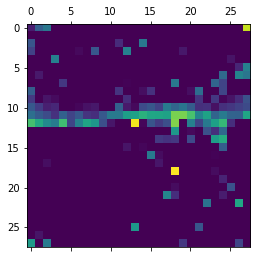

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

#### Visualizing all activations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


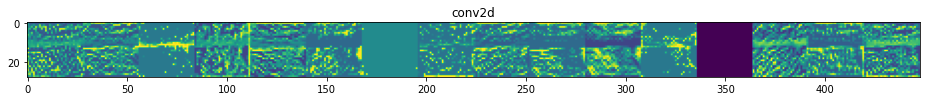

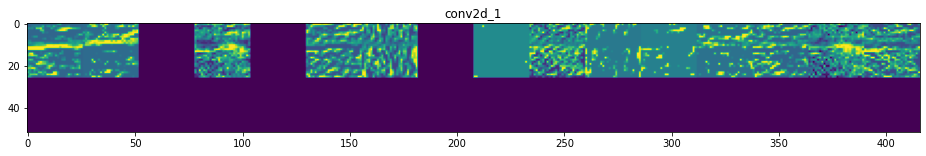

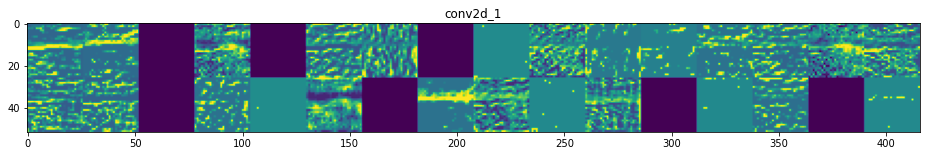

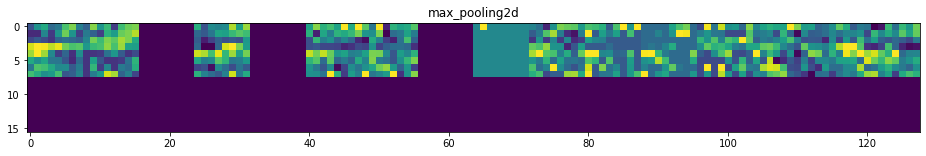

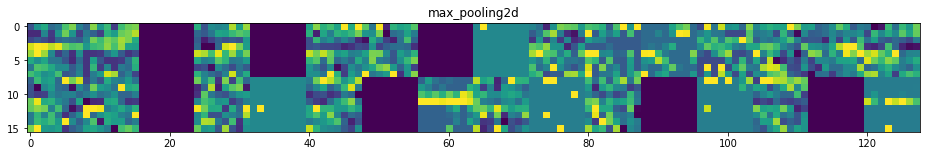

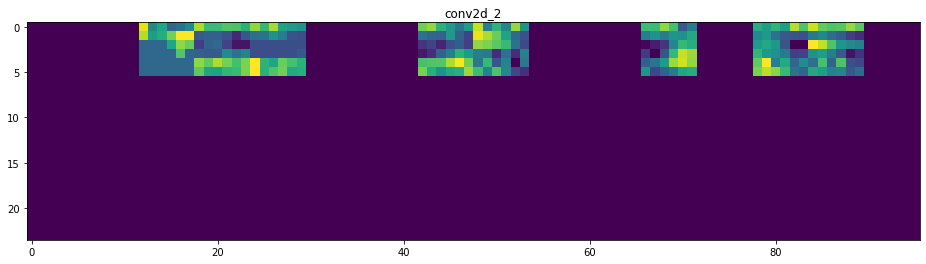

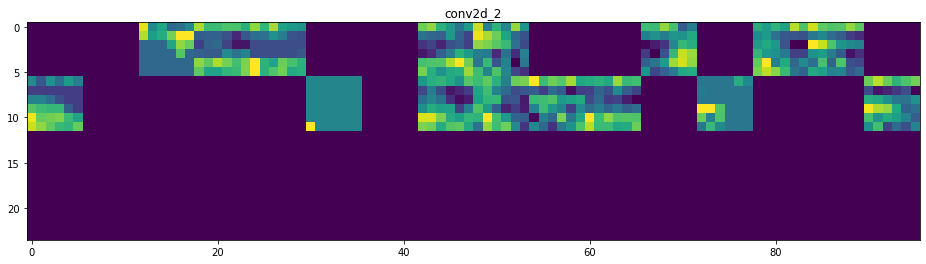

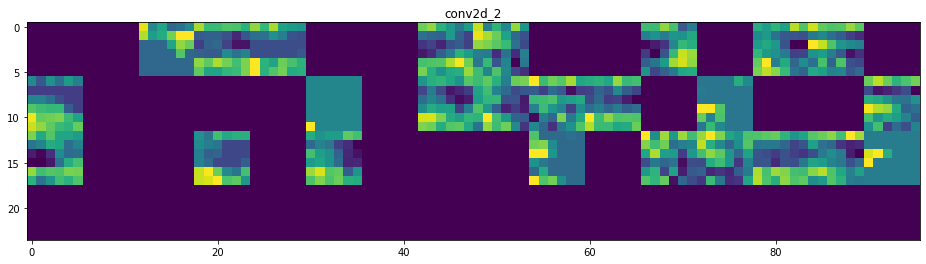

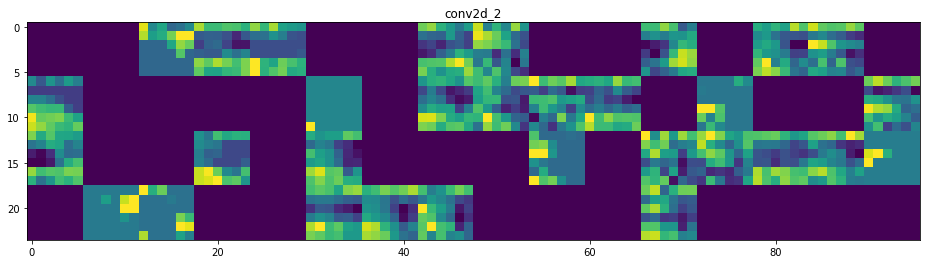

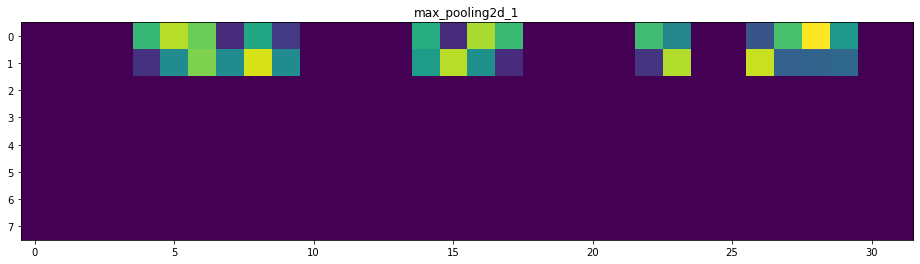

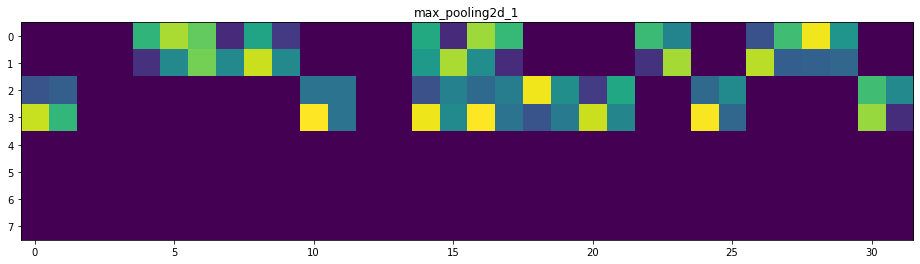

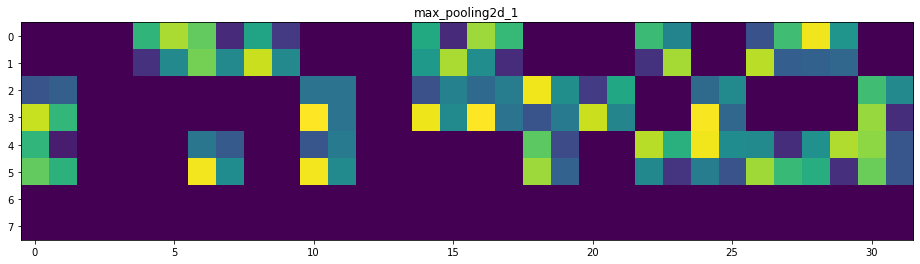

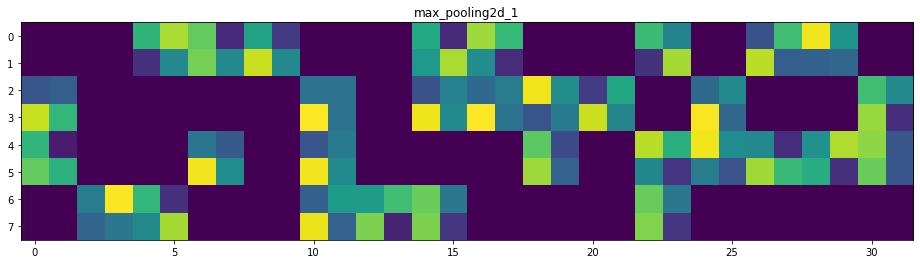

In [ ]:
layer_names = []
for layer in model.layers[:5]:
  layer_names.append(layer.name) #Create a list containing all layer names

images_per_row = 16


for layer_name, layer_activation in zip(layer_names, activations):#Display feature map
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size*n_cols, images_per_row*size))
  for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col*images_per_row + row]
      channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


### Interpretations


1) The first layers detect simpler and more general patterns. The first few 
layers retain the most of the given input image and the convolution filters are activated at every part of the image. We can see the difference between a water way and other land use types

2) As we advanved into the deeper layers in the architecture, the features that are extracted by the fitlers become less interpretable. In fact, some layers have a lot of blank convulution outputs. This means that the pattern encoded by the filters were not found in the input image. Most probably, these patterns must be complex shapes that are not present in this input image.

3) This method of feature extraction is not very useful in our case because the images don't have a clear boundary or border that we are trying to identify. This method is more useful when we are trying to also do edge detections, such as detect shapes in an image, faces, types of animals etc. 

Ref: https://towardsdatascience.com/visual-interpretability-for-convolutional-neural-networks-2453856210ce

# Visualizing Filters by maximizing the activation of a specific filter in a target layer





##### Ref - https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb

In this method, we follow the approach in the code provided here - https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb
The ResNet50V2 is used to visualize patterns that the model understands. The approach is to maximize the activation of a specific filter in a target layer and represent a visualization of the pattern that filter corresponds to. 

### Load the feature extraction model



In [ ]:
# The dimensions of our input image
img_width_filter = 180
img_height_filter = 180
# Here we'll visualize the filters from the target layer.
# Set the target layer based on the `model.summary()` layers. Update this to a different layer if you want to change this. 

loaded_model.summary()


layer_name = "conv2d_2"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [ ]:
# Set up a model that returns the activation values for our target layer
layer = loaded_model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=loaded_model.inputs, outputs=layer.output)


## Setting up gradient ascent process

The loss function to maximize is the mean of the activation of a specific filter in the target layer. Border pixels are excluded.

In [ ]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


In [ ]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [ ]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width_filter, img_height_filter, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= np.mean(img)
    img /= np.std(img) + 1e-5
    img *= 0.15
    # Center crop
    img = img[25:-25, 25:-25, :]
    
    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")

    # Center crop
    #img = tf.image.central_crop(img, 0.5)

    return img


In [ ]:
from IPython.display import Image, display


loss, img = visualize_filter(62)
keras.preprocessing.image.save_img("2.png", img)

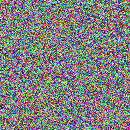

In [ ]:
display(Image("2.png", width = 180, height = 180))

## Visualizing all fitlers in the target layer

The target layer has 32 filters. First create an 8x4 grid for the 32 filters in the target layer. 

In [ ]:
#Compute image inputs that maximize per-filter activations for the 32 filters in the target layer
all_imgs = []
for filter_index in range(64):
  print("Processing filter %d" % (filter_index,))
  loss, img = visualize_filter(filter_index)

  all_imgs.append(img)



#Building a black black picture for the 8*4 filters, with image size 128*128, 5px margin in between
margin = 5
n1  = 8
n2 = 8
cropped_width = img_width_filter - 25 * 2
cropped_height = img_height_filter- 25 * 2
width = n1 * cropped_width + (n1 -1) * margin
height = n2 * cropped_height + (n2 -1)*margin
stitched_filters = np.zeros((width, height, 3))




#Fill picture with saved filters
for i in range(n1):
  for j in range(n2):
    img = all_imgs[i * n2 + j]
    stitched_filters[
                      (cropped_width + margin)*i : (cropped_width + margin)*i + cropped_width,
                      (cropped_height + margin)*j : (cropped_height + margin)*j + cropped_height, :]  = img
keras.preprocessing.image.save_img("stitched_filterimages_conv2d_2.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

Conv2d_1: All the filters


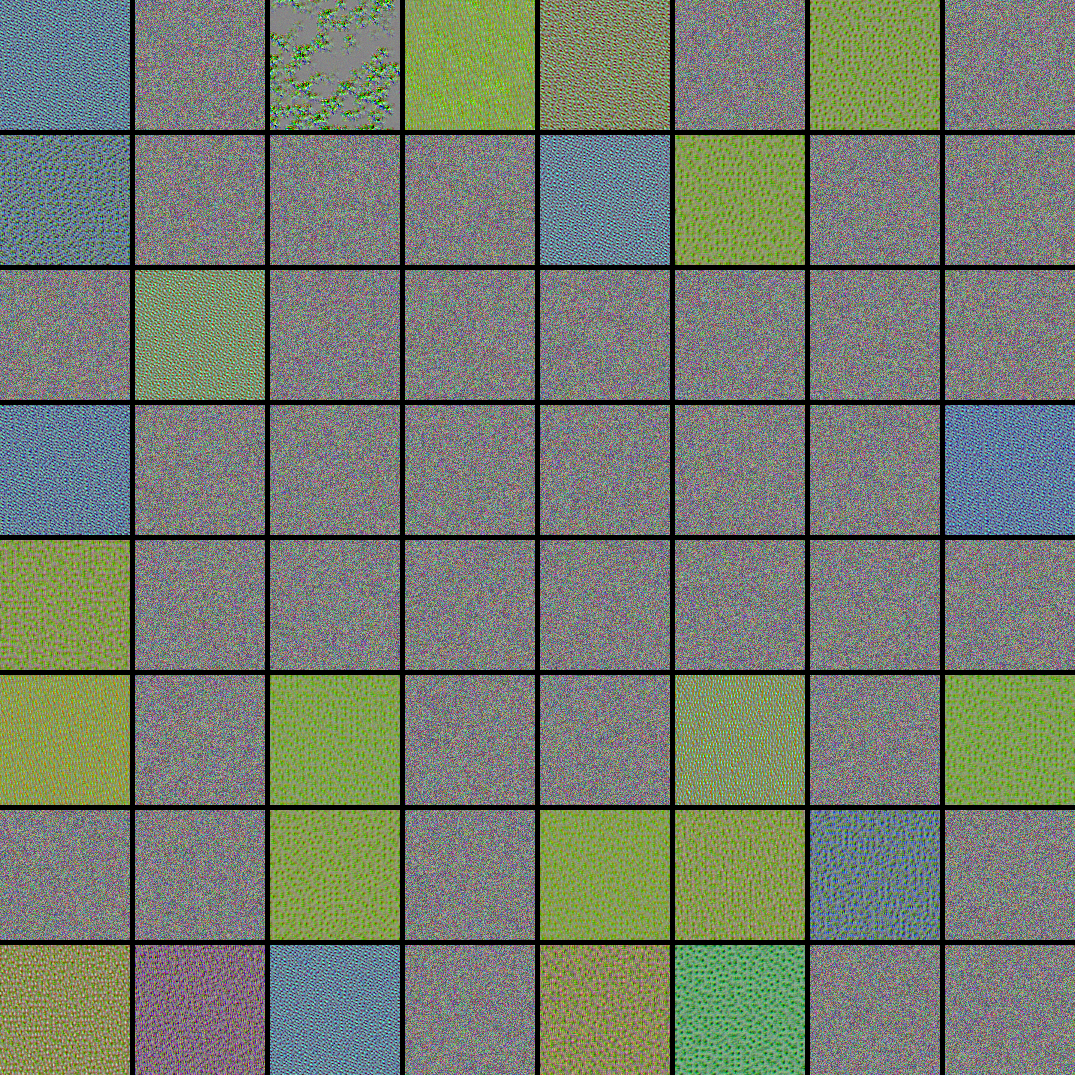

In [ ]:
print("Conv2d_1: All the filters")
display(Image("stitched_filterimages_conv2d_2.png"))

In [ ]:
print("Conv2d_2: All the filters")
display(Image("stitched_filterimages_conv2d_2.png"))

## Interpretations


1) This code systematically displays what sort of input (they're not unique) maximizes each filter in each layer, giving us a neat visualization of the convnet's modular-hierarchical decomposition of its visual space.

2) The first layers basically just encodes direction and color. These direction and color filters then get combined into basic grid and spot textures. These textures gradually get combined into increasingly complex patterns.

3) You can think of the filters in each layer as a basis of vectors, typically overcomplete, that can be used to encode the layer's input in a compact way. The filters become more intricate as they start incorporating information from an increasingly larger spatial extent.

Further details ([Ref](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html))

In [ ]:
## Testing on another image:
## Source of image: https://viewer.nationalmap.gov/basic/?basemap=b1&category=hro,naip&title=Imagery%20View#productSearch